In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [32]:
!wget eva_finetuned_epoch_2_acc_85.55.pth


--2024-11-09 16:40:52--  http://eva_finetuned_epoch_2_acc_85.55.pth/
Resolving eva_finetuned_epoch_2_acc_85.55.pth (eva_finetuned_epoch_2_acc_85.55.pth)... failed: Name or service not known.
wget: unable to resolve host address 'eva_finetuned_epoch_2_acc_85.55.pth'


In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))


In [33]:
from IPython.display import FileLink, display
download_file_name = "/kaggle/working/eva_finetuned_epoch_2_acc_85.zip"
display(FileLink(download_file_name))

/kaggle/working/eva_finetuned_epoch_2_acc_85.zip

In [1]:
import pandas as pd

# Load the data
data_path = '../input/mva-recvis-2024/class2category.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(data.head())


       Class  Category
0  n01484850         0
1  n01494475         1
2  n01496331         2
3  n01514668         3
4  n01518878         4


In [16]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Paths to train and test directories
train_dir = '../input/mva-recvis-2024/sketch_recvis2024/sketch_recvis2024/train_images'
test_dir = '../input/mva-recvis-2024/sketch_recvis2024/sketch_recvis2024/test_images'


In [17]:
# Define transformations for the train and test sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to a standard size
    transforms.RandomHorizontalFlip(),  # Data augmentation: random horizontal flip
    transforms.ToTensor(),              # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained models
])


In [18]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [21]:
# Create data loaders
batch_size = 4 # You can adjust batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [22]:
# Verify train_loader
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels)
    break


Batch of images shape: torch.Size([4, 3, 224, 224])
Batch of labels shape: tensor([446, 327, 439, 306])


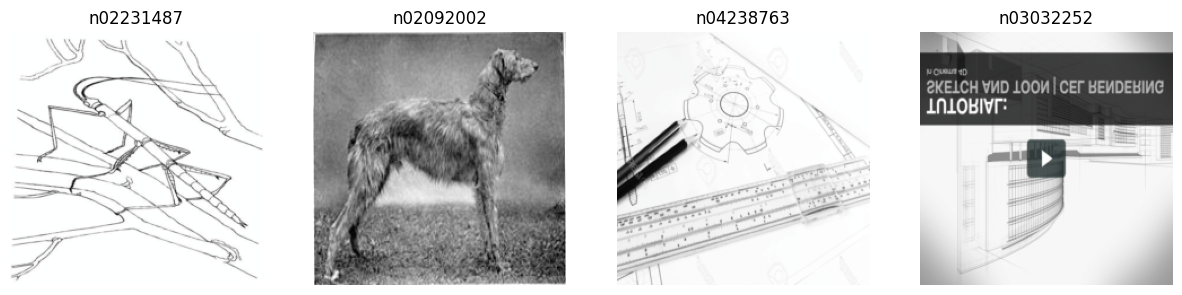

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a batch of images with labels
def show_images_batch(dataloader, class_names):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))
    
    # Plot the images in a grid
    fig, axes = plt.subplots(1, len(images), figsize=(15, 15))
    for i, (img, label) in enumerate(zip(images, labels)):
        # Move the channels to the last dimension for plotting
        img = img.permute(1, 2, 0).numpy()
        
        # Undo normalization for display purposes
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] for display
        
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.show()

# Class names are retrieved from the dataset
class_names = train_dataset.classes

# Display the batch of images
show_images_batch(train_loader, class_names)


# **CLIP**

In [24]:
!pip install transformers torchvision


In [25]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like openai/clip-vit-base-patch32 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

# EVA-CLIP


In [3]:
import torch

In [4]:

from PIL import Image
import timm



model = timm.create_model('eva_giant_patch14_336.clip_ft_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms_ = timm.data.create_transform(**data_config, is_training=False)


# output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

# top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


model.safetensors:  98%|#########8| 3.98G/4.05G [00:00<?, ?B/s]

In [5]:
import torch
import torch.nn as nn

class EVA_finetuner(nn.Module):
    def __init__(self, model, num_classes=400):
        """
        Initializes the EVA model, modifying only the classifier layer to match the number of classes.

        Parameters:
        - model: The pre-trained Eva model.
        - num_classes: The number of classes in the new dataset.
        """
        super(EVA_finetuner, self).__init__()

        # Keep the rest of the model as it is
        self.model = model

        # Freeze all layers except the classifier (head)
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify the final classifier layer to match the number of classes
        self.model.head = nn.Linear(in_features=1408, out_features=num_classes)

        # Ensure that the new classifier layers will be trained
        for param in self.model.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        """
        Forward pass through the modified model.
        """
        return self.model(x)


In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader


from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import pandas as pd

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [7]:
# imagenet_cls_map = {'n02119789': 'kit fox, Vulpes macrotis', 'n02100735': 'English setter', 'n02096294': 'Australian terrier', 'n02066245': 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus', 'n02509815': 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'n02124075': 'Egyptian cat', 'n02417914': 'ibex, Capra ibex', 'n02123394': 'Persian cat', 'n02125311': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'n02423022': 'gazelle', 'n02346627': 'porcupine, hedgehog', 'n02077923': 'sea lion', 'n02447366': 'badger', 'n02109047': 'Great Dane', 'n02092002': 'Scottish deerhound, deerhound', 'n02071294': 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca', 'n02442845': 'mink', 'n02504458': 'African elephant, Loxodonta africana', 'n02114712': 'red wolf, maned wolf, Canis rufus, Canis niger', 'n02128925': 'jaguar, panther, Panthera onca, Felis onca', 'n02117135': 'hyena, hyaena', 'n02493509': 'titi, titi monkey', 'n02457408': 'three-toed sloth, ai, Bradypus tridactylus', 'n02389026': 'sorrel', 'n02443484': 'black-footed ferret, ferret, Mustela nigripes', 'n02110341': 'dalmatian, coach dog, carriage dog', 'n02093256': 'Staffordshire bullterrier, Staffordshire bull terrier', 'n02106382': 'Bouvier des Flandres, Bouviers des Flandres', 'n02441942': 'weasel', 'n02113712': 'miniature poodle', 'n02415577': 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'n02356798': 'fox squirrel, eastern fox squirrel, Sciurus niger', 'n02488702': 'colobus, colobus monkey', 'n02123159': 'tiger cat', 'n02422699': 'impala, Aepyceros melampus', 'n02114855': 'coyote, prairie wolf, brush wolf, Canis latrans', 'n02094433': 'Yorkshire terrier', 'n02111277': 'Newfoundland, Newfoundland dog', 'n02119022': 'red fox, Vulpes vulpes', 'n02422106': 'hartebeest', 'n02120505': 'grey fox, gray fox, Urocyon cinereoargenteus', 'n02086079': 'Pekinese, Pekingese, Peke', 'n02484975': 'guenon, guenon monkey', 'n02137549': 'mongoose', 'n02500267': 'indri, indris, Indri indri, Indri brevicaudatus', 'n02129604': 'tiger, Panthera tigris', 'n02396427': 'wild boar, boar, Sus scrofa', 'n02391049': 'zebra', 'n02412080': 'ram, tup', 'n02480495': 'orangutan, orang, orangutang, Pongo pygmaeus', 'n02110806': 'basenji', 'n02128385': 'leopard, Panthera pardus', 'n02100583': 'vizsla, Hungarian pointer', 'n02494079': 'squirrel monkey, Saimiri sciureus', 'n02123597': 'Siamese cat, Siamese', 'n02481823': 'chimpanzee, chimp, Pan troglodytes', 'n02105505': 'komondor', 'n02489166': 'proboscis monkey, Nasalis larvatus', 'n02364673': 'guinea pig, Cavia cobaya', 'n02114548': 'white wolf, Arctic wolf, Canis lupus tundrarum', 'n02134084': 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 'n02480855': 'gorilla, Gorilla gorilla', 'n02403003': 'ox', 'n02108551': 'Tibetan mastiff', 'n02493793': 'spider monkey, Ateles geoffroyi', 'n02107142': 'Doberman, Doberman pinscher', 'n02397096': 'warthog', 'n02437312': 'Arabian camel, dromedary, Camelus dromedarius', 'n02483708': 'siamang, Hylobates syndactylus, Symphalangus syndactylus', 'n02099601': 'golden retriever', 'n02106166': 'Border collie', 'n02326432': 'hare', 'n02108089': 'boxer', 'n02486261': 'patas, hussar monkey, Erythrocebus patas', 'n02486410': 'baboon', 'n02487347': 'macaque', 'n02492035': 'capuchin, ringtail, Cebus capucinus', 'n02099267': 'flat-coated retriever', 'n02395406': 'hog, pig, grunter, squealer, Sus scrofa', 'n02109961': 'Eskimo dog, husky', 'n02101388': 'Brittany spaniel', 'n03187595': 'dial telephone, dial phone', 'n03733281': 'maze, labyrinth', 'n02101006': 'Gordon setter', 'n02115641': 'dingo, warrigal, warragal, Canis dingo', 'n02342885': 'hamster', 'n02120079': 'Arctic fox, white fox, Alopex lagopus', 'n02408429': 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis', 'n02133161': 'American black bear, black bear, Ursus americanus, Euarctos americanus', 'n02328150': 'Angora, Angora rabbit', 'n02410509': 'bison', 'n02492660': 'howler monkey, howler', 'n02398521': 'hippopotamus, hippo, river horse, Hippopotamus amphibius', 'n02510455': 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca', 'n02123045': 'tabby, tabby cat', 'n02490219': 'marmoset', 'n02109525': 'Saint Bernard, St Bernard', 'n02454379': 'armadillo', 'n02090379': 'redbone', 'n02443114': 'polecat, fitch, foulmart, foumart, Mustela putorius', 'n02361337': 'marmot', 'n02483362': 'gibbon, Hylobates lar', 'n02437616': 'llama', 'n02325366': 'wood rabbit, cottontail, cottontail rabbit', 'n02129165': 'lion, king of beasts, Panthera leo', 'n02100877': 'Irish setter, red setter', 'n02074367': 'dugong, Dugong dugon', 'n02504013': 'Indian elephant, Elephas maximus', 'n02363005': 'beaver', 'n02497673': 'Madagascar cat, ring-tailed lemur, Lemur catta', 'n02087394': 'Rhodesian ridgeback', 'n02127052': 'lynx, catamount', 'n02116738': 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus', 'n02488291': 'langur', 'n02114367': 'timber wolf, grey wolf, gray wolf, Canis lupus', 'n02130308': 'cheetah, chetah, Acinonyx jubatus', 'n02134418': 'sloth bear, Melursus ursinus, Ursus ursinus', 'n02106662': 'German shepherd, German shepherd dog, German police dog, alsatian', 'n02444819': 'otter', 'n01882714': 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'n01871265': 'tusker', 'n01872401': 'echidna, spiny anteater, anteater', 'n01877812': 'wallaby, brush kangaroo', 'n01873310': 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus', 'n01883070': 'wombat', 'n04086273': 'revolver, six-gun, six-shooter', 'n04507155': 'umbrella', 'n04147183': 'schooner', 'n04254680': 'soccer ball', 'n02672831': 'accordion, piano accordion, squeeze box', 'n02219486': 'ant, emmet, pismire', 'n02317335': 'starfish, sea star', 'n01968897': 'chambered nautilus, pearly nautilus, nautilus', 'n03452741': 'grand piano, grand', 'n03642806': 'laptop, laptop computer', 'n07745940': 'strawberry', 'n02690373': 'airliner', 'n04552348': 'warplane, military plane', 'n02692877': 'airship, dirigible', 'n02782093': 'balloon', 'n04266014': 'space shuttle', 'n03344393': 'fireboat', 'n03447447': 'gondola', 'n04273569': 'speedboat', 'n03662601': 'lifeboat', 'n02951358': 'canoe', 'n04612504': 'yawl', 'n02981792': 'catamaran', 'n04483307': 'trimaran', 'n03095699': 'container ship, containership, container vessel', 'n03673027': 'liner, ocean liner', 'n03947888': 'pirate, pirate ship', 'n02687172': 'aircraft carrier, carrier, flattop, attack aircraft carrier', 'n04347754': 'submarine, pigboat, sub, U-boat', 'n04606251': 'wreck', 'n03478589': 'half track', 'n04389033': 'tank, army tank, armored combat vehicle, armoured combat vehicle', 'n03773504': 'missile', 'n02860847': 'bobsled, bobsleigh, bob', 'n03218198': 'dogsled, dog sled, dog sleigh', 'n02835271': 'bicycle-built-for-two, tandem bicycle, tandem', 'n03792782': 'mountain bike, all-terrain bike, off-roader', 'n03393912': 'freight car', 'n03895866': 'passenger car, coach, carriage', 'n02797295': 'barrow, garden cart, lawn cart, wheelbarrow', 'n04204347': 'shopping cart', 'n03791053': 'motor scooter, scooter', 'n03384352': 'forklift', 'n03272562': 'electric locomotive', 'n04310018': 'steam locomotive', 'n02704792': 'amphibian, amphibious vehicle', 'n02701002': 'ambulance', 'n02814533': 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'n02930766': 'cab, hack, taxi, taxicab', 'n03100240': 'convertible', 'n03594945': 'jeep, landrover', 'n03670208': 'limousine, limo', 'n03770679': 'minivan', 'n03777568': 'Model T', 'n04037443': 'racer, race car, racing car', 'n04285008': 'sports car, sport car', 'n03444034': 'go-kart', 'n03445924': 'golfcart, golf cart', 'n03785016': 'moped', 'n04252225': 'snowplow, snowplough', 'n03345487': 'fire engine, fire truck', 'n03417042': 'garbage truck, dustcart', 'n03930630': 'pickup, pickup truck', 'n04461696': 'tow truck, tow car, wrecker', 'n04467665': 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi', 'n03796401': 'moving van', 'n03977966': 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 'n04065272': 'recreational vehicle, RV, R.V.', 'n04335435': 'streetcar, tram, tramcar, trolley, trolley car', 'n04252077': 'snowmobile', 'n04465501': 'tractor', 'n03776460': 'mobile home, manufactured home', 'n04482393': 'tricycle, trike, velocipede', 'n04509417': 'unicycle, monocycle', 'n03538406': 'horse cart, horse-cart', 'n03788365': 'mosquito net', 'n03868242': 'oxcart', 'n02804414': 'bassinet', 'n03125729': 'cradle', 'n03131574': 'crib, cot', 'n03388549': 'four-poster', 'n02870880': 'bookcase', 'n03018349': 'china cabinet, china closet', 'n03742115': 'medicine chest, medicine cabinet', 'n03016953': 'chiffonier, commode', 'n04380533': 'table lamp', 'n03337140': 'file, file cabinet, filing cabinet', 'n03902125': 'pay-phone, pay-station', 'n03891251': 'park bench', 'n02791124': 'barber chair', 'n04429376': 'throne', 'n03376595': 'folding chair', 'n04099969': 'rocking chair, rocker', 'n04344873': 'studio couch, day bed', 'n04447861': 'toilet seat', 'n03179701': 'desk', 'n03982430': 'pool table, billiard table, snooker table', 'n03201208': 'dining table, board', 'n03290653': 'entertainment center', 'n04550184': 'wardrobe, closet, press', 'n07742313': 'Granny Smith', 'n07747607': 'orange', 'n07749582': 'lemon', 'n07753113': 'fig', 'n07753275': 'pineapple, ananas', 'n07753592': 'banana', 'n07754684': 'jackfruit, jak, jack', 'n07760859': 'custard apple', 'n07768694': 'pomegranate', 'n12267677': 'acorn', 'n12620546': 'hip, rose hip, rosehip', 'n13133613': 'ear, spike, capitulum', 'n11879895': 'rapeseed', 'n12144580': 'corn', 'n12768682': 'buckeye, horse chestnut, conker', 'n03854065': 'organ, pipe organ', 'n04515003': 'upright, upright piano', 'n03017168': 'chime, bell, gong', 'n03249569': 'drum, membranophone, tympan', 'n03447721': 'gong, tam-tam', 'n03720891': 'maraca', 'n03721384': 'marimba, xylophone', 'n04311174': 'steel drum', 'n02787622': 'banjo', 'n02992211': 'cello, violoncello', 'n03637318': 'lampshade, lamp shade', 'n03495258': 'harp', 'n02676566': 'acoustic guitar', 'n03272010': 'electric guitar', 'n03110669': 'cornet, horn, trumpet, trump', 'n03394916': 'French horn, horn', 'n04487394': 'trombone', 'n03494278': 'harmonica, mouth organ, harp, mouth harp', 'n03840681': 'ocarina, sweet potato', 'n03884397': 'panpipe, pandean pipe, syrinx', 'n02804610': 'bassoon', 'n04141076': 'sax, saxophone', 'n03372029': 'flute, transverse flute', 'n11939491': 'daisy', 'n12057211': "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum", 'n09246464': 'cliff, drop, drop-off', 'n09468604': 'valley, vale', 'n09193705': 'alp', 'n09472597': 'volcano', 'n09399592': 'promontory, headland, head, foreland', 'n09421951': 'sandbar, sand bar', 'n09256479': 'coral reef', 'n09332890': 'lakeside, lakeshore', 'n09428293': 'seashore, coast, seacoast, sea-coast', 'n09288635': 'geyser', 'n03498962': 'hatchet', 'n03041632': 'cleaver, meat cleaver, chopper', 'n03658185': 'letter opener, paper knife, paperknife', 'n03954731': "plane, carpenter's plane, woodworking plane", 'n03995372': 'power drill', 'n03649909': 'lawn mower, mower', 'n03481172': 'hammer', 'n03109150': 'corkscrew, bottle screw', 'n02951585': 'can opener, tin opener', 'n03970156': "plunger, plumber's helper", 'n04154565': 'screwdriver', 'n04208210': 'shovel', 'n03967562': 'plow, plough', 'n03000684': 'chain saw, chainsaw', 'n01514668': 'cock', 'n01514859': 'hen', 'n01518878': 'ostrich, Struthio camelus', 'n01530575': 'brambling, Fringilla montifringilla', 'n01531178': 'goldfinch, Carduelis carduelis', 'n01532829': 'house finch, linnet, Carpodacus mexicanus', 'n01534433': 'junco, snowbird', 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'n01558993': 'robin, American robin, Turdus migratorius', 'n01560419': 'bulbul', 'n01580077': 'jay', 'n01582220': 'magpie', 'n01592084': 'chickadee', 'n01601694': 'water ouzel, dipper', 'n01608432': 'kite', 'n01614925': 'bald eagle, American eagle, Haliaeetus leucocephalus', 'n01616318': 'vulture', 'n01622779': 'great grey owl, great gray owl, Strix nebulosa', 'n01795545': 'black grouse', 'n01796340': 'ptarmigan', 'n01797886': 'ruffed grouse, partridge, Bonasa umbellus', 'n01798484': 'prairie chicken, prairie grouse, prairie fowl', 'n01806143': 'peacock', 'n01806567': 'quail', 'n01807496': 'partridge', 'n01817953': 'African grey, African gray, Psittacus erithacus', 'n01818515': 'macaw', 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', 'n01820546': 'lorikeet', 'n01824575': 'coucal', 'n01828970': 'bee eater', 'n01829413': 'hornbill', 'n01833805': 'hummingbird', 'n01843065': 'jacamar', 'n01843383': 'toucan', 'n01847000': 'drake', 'n01855032': 'red-breasted merganser, Mergus serrator', 'n01855672': 'goose', 'n01860187': 'black swan, Cygnus atratus', 'n02002556': 'white stork, Ciconia ciconia', 'n02002724': 'black stork, Ciconia nigra', 'n02006656': 'spoonbill', 'n02007558': 'flamingo', 'n02009912': 'American egret, great white heron, Egretta albus', 'n02009229': 'little blue heron, Egretta caerulea', 'n02011460': 'bittern', 'n02012849': 'crane', 'n02013706': 'limpkin, Aramus pictus', 'n02018207': 'American coot, marsh hen, mud hen, water hen, Fulica americana', 'n02018795': 'bustard', 'n02025239': 'ruddy turnstone, Arenaria interpres', 'n02027492': 'red-backed sandpiper, dunlin, Erolia alpina', 'n02028035': 'redshank, Tringa totanus', 'n02033041': 'dowitcher', 'n02037110': 'oystercatcher, oyster catcher', 'n02017213': 'European gallinule, Porphyrio porphyrio', 'n02051845': 'pelican', 'n02056570': 'king penguin, Aptenodytes patagonica', 'n02058221': 'albatross, mollymawk', 'n01484850': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'n01491361': 'tiger shark, Galeocerdo cuvieri', 'n01494475': 'hammerhead, hammerhead shark', 'n01496331': 'electric ray, crampfish, numbfish, torpedo', 'n01498041': 'stingray', 'n02514041': 'barracouta, snoek', 'n02536864': 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', 'n01440764': 'tench, Tinca tinca', 'n01443537': 'goldfish, Carassius auratus', 'n02526121': 'eel', 'n02606052': 'rock beauty, Holocanthus tricolor', 'n02607072': 'anemone fish', 'n02643566': 'lionfish', 'n02655020': 'puffer, pufferfish, blowfish, globefish', 'n02640242': 'sturgeon', 'n02641379': 'gar, garfish, garpike, billfish, Lepisosteus osseus', 'n01664065': 'loggerhead, loggerhead turtle, Caretta caretta', 'n01667114': 'mud turtle', 'n01667778': 'terrapin', 'n01669191': 'box turtle, box tortoise', 'n01675722': 'banded gecko', 'n01677366': 'common iguana, iguana, Iguana iguana', 'n01682714': 'American chameleon, anole, Anolis carolinensis', 'n01685808': 'whiptail, whiptail lizard', 'n01687978': 'agama', 'n01688243': 'frilled lizard, Chlamydosaurus kingi', 'n01689811': 'alligator lizard', 'n01692333': 'Gila monster, Heloderma suspectum', 'n01693334': 'green lizard, Lacerta viridis', 'n01694178': 'African chameleon, Chamaeleo chamaeleon', 'n01695060': 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'n01704323': 'triceratops', 'n01697457': 'African crocodile, Nile crocodile, Crocodylus niloticus', 'n01698640': 'American alligator, Alligator mississipiensis', 'n01728572': 'thunder snake, worm snake, Carphophis amoenus', 'n01728920': 'ringneck snake, ring-necked snake, ring snake', 'n01729322': 'hognose snake, puff adder, sand viper', 'n01729977': 'green snake, grass snake', 'n01734418': 'king snake, kingsnake', 'n01735189': 'garter snake, grass snake', 'n01737021': 'water snake', 'n01739381': 'vine snake', 'n01740131': 'night snake, Hypsiglena torquata', 'n01742172': 'boa constrictor, Constrictor constrictor', 'n01744401': 'rock python, rock snake, Python sebae', 'n01748264': 'Indian cobra, Naja naja', 'n01749939': 'green mamba', 'n01751748': 'sea snake', 'n01753488': 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'n04326547': 'stone wall', 'n01756291': 'sidewinder, horned rattlesnake, Crotalus cerastes', 'n01629819': 'European fire salamander, Salamandra salamandra', 'n01630670': 'common newt, Triturus vulgaris', 'n01631663': 'eft', 'n01632458': 'spotted salamander, Ambystoma maculatum', 'n01632777': 'axolotl, mud puppy, Ambystoma mexicanum', 'n01641577': 'bullfrog, Rana catesbeiana', 'n01644373': 'tree frog, tree-frog', 'n01644900': 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'n04579432': 'whistle', 'n04592741': 'wing', 'n03876231': 'paintbrush', 'n03868863': 'oxygen mask', 'n04251144': 'snorkel', 'n03691459': 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system', 'n03759954': 'microphone, mike', 'n04152593': 'screen, CRT screen', 'n03793489': 'mouse, computer mouse', 'n03271574': 'electric fan, blower', 'n03843555': 'oil filter', 'n04332243': 'strainer', 'n04265275': 'space heater', 'n04330267': 'stove', 'n03467068': 'guillotine', 'n02794156': 'barometer', 'n04118776': 'rule, ruler', 'n03841143': 'odometer, hodometer, mileometer, milometer', 'n04141975': 'scale, weighing machine', 'n02708093': 'analog clock', 'n03196217': 'digital clock', 'n04548280': 'wall clock', 'n03544143': 'hourglass', 'n04355338': 'sundial', 'n03891332': 'parking meter', 'n04328186': 'stopwatch, stop watch', 'n03197337': 'digital watch', 'n04317175': 'stethoscope', 'n04376876': 'syringe', 'n03706229': 'magnetic compass', 'n02841315': 'binoculars, field glasses, opera glasses', 'n04009552': 'projector', 'n04356056': 'sunglasses, dark glasses, shades', 'n03692522': "loupe, jeweler's loupe", 'n04044716': 'radio telescope, radio reflector', 'n02879718': 'bow', 'n02950826': 'cannon', 'n02749479': 'assault rifle, assault gun', 'n04090263': 'rifle', 'n04008634': 'projectile, missile', 'n03085013': 'computer keyboard, keypad', 'n04505470': 'typewriter keyboard', 'n03126707': 'crane', 'n03666591': 'lighter, light, igniter, ignitor', 'n02666196': 'abacus', 'n02977058': 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM', 'n04238763': 'slide rule, slipstick', 'n03180011': 'desktop computer', 'n03485407': 'hand-held computer, hand-held microcomputer', 'n03832673': 'notebook, notebook computer', 'n03874599': 'padlock', 'n03496892': 'harvester, reaper', 'n04428191': 'thresher, thrasher, threshing machine', 'n04004767': 'printer', 'n04243546': 'slot, one-armed bandit', 'n04525305': 'vending machine', 'n04179913': 'sewing machine', 'n03602883': 'joystick', 'n04372370': 'switch, electric switch, electrical switch', 'n03532672': 'hook, claw', 'n02974003': 'car wheel', 'n03874293': 'paddlewheel, paddle wheel', 'n03944341': 'pinwheel', 'n03992509': "potter's wheel", 'n03425413': 'gas pump, gasoline pump, petrol pump, island dispenser', 'n02966193': 'carousel, carrousel, merry-go-round, roundabout, whirligig', 'n04371774': 'swing', 'n04067472': 'reel', 'n04040759': 'radiator', 'n04019541': 'puck, hockey puck', 'n03492542': 'hard disc, hard disk, fixed disk', 'n04355933': 'sunglass', 'n03929660': 'pick, plectrum, plectron', 'n02965783': 'car mirror', 'n04258138': 'solar dish, solar collector, solar furnace', 'n04074963': 'remote control, remote', 'n03208938': 'disk brake, disc brake', 'n02910353': 'buckle', 'n03476684': 'hair slide', 'n03627232': 'knot', 'n03075370': 'combination lock', 'n06359193': 'web site, website, internet site, site', 'n03804744': 'nail', 'n04127249': 'safety pin', 'n04153751': 'screw', 'n03803284': 'muzzle', 'n04162706': 'seat belt, seatbelt', 'n04228054': 'ski', 'n02948072': 'candle, taper, wax light', 'n03590841': "jack-o'-lantern", 'n04286575': 'spotlight, spot', 'n04456115': 'torch', 'n03814639': 'neck brace', 'n03933933': 'pier', 'n04485082': 'tripod', 'n03733131': 'maypole', 'n03483316': 'hand blower, blow dryer, blow drier, hair dryer, hair drier', 'n03794056': 'mousetrap', 'n04275548': "spider web, spider's web", 'n01768244': 'trilobite', 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio', 'n01770393': 'scorpion', 'n01773157': 'black and gold garden spider, Argiope aurantia', 'n01773549': 'barn spider, Araneus cavaticus', 'n01773797': 'garden spider, Aranea diademata', 'n01774384': 'black widow, Latrodectus mactans', 'n01774750': 'tarantula', 'n01775062': 'wolf spider, hunting spider', 'n01776313': 'tick', 'n01784675': 'centipede', 'n01990800': 'isopod', 'n01978287': 'Dungeness crab, Cancer magister', 'n01978455': 'rock crab, Cancer irroratus', 'n01980166': 'fiddler crab', 'n01981276': 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica', 'n01983481': 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'n01985128': 'crayfish, crawfish, crawdad, crawdaddy', 'n01986214': 'hermit crab', 'n02165105': 'tiger beetle', 'n02165456': 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'n02167151': 'ground beetle, carabid beetle', 'n02168699': 'long-horned beetle, longicorn, longicorn beetle', 'n02169497': 'leaf beetle, chrysomelid', 'n02172182': 'dung beetle', 'n02174001': 'rhinoceros beetle', 'n02177972': 'weevil', 'n02190166': 'fly', 'n02206856': 'bee', 'n02226429': 'grasshopper, hopper', 'n02229544': 'cricket', 'n02231487': 'walking stick, walkingstick, stick insect', 'n02233338': 'cockroach, roach', 'n02236044': 'mantis, mantid', 'n02256656': 'cicada, cicala', 'n02259212': 'leafhopper', 'n02264363': 'lacewing, lacewing fly', 'n02268443': "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", 'n02268853': 'damselfly', 'n02276258': 'admiral', 'n02277742': 'ringlet, ringlet butterfly', 'n02279972': 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'n02280649': 'cabbage butterfly', 'n02281406': 'sulphur butterfly, sulfur butterfly', 'n02281787': 'lycaenid, lycaenid butterfly', 'n01910747': 'jellyfish', 'n01914609': 'sea anemone, anemone', 'n01917289': 'brain coral', 'n01924916': 'flatworm, platyhelminth', 'n01930112': 'nematode, nematode worm, roundworm', 'n01943899': 'conch', 'n01944390': 'snail', 'n01945685': 'slug', 'n01950731': 'sea slug, nudibranch', 'n01955084': 'chiton, coat-of-mail shell, sea cradle, polyplacophore', 'n02319095': 'sea urchin', 'n02321529': 'sea cucumber, holothurian', 'n03584829': 'iron, smoothing iron', 'n03297495': 'espresso maker', 'n03761084': 'microwave, microwave oven', 'n03259280': 'Dutch oven', 'n04111531': 'rotisserie', 'n04442312': 'toaster', 'n04542943': 'waffle iron', 'n04517823': 'vacuum, vacuum cleaner', 'n03207941': 'dishwasher, dish washer, dishwashing machine', 'n04070727': 'refrigerator, icebox', 'n04554684': 'washer, automatic washer, washing machine', 'n03133878': 'Crock Pot', 'n03400231': 'frying pan, frypan, skillet', 'n04596742': 'wok', 'n02939185': 'caldron, cauldron', 'n03063689': 'coffeepot', 'n04398044': 'teapot', 'n04270147': 'spatula', 'n02699494': 'altar', 'n04486054': 'triumphal arch', 'n03899768': 'patio, terrace', 'n04311004': 'steel arch bridge', 'n04366367': 'suspension bridge', 'n04532670': 'viaduct', 'n02793495': 'barn', 'n03457902': 'greenhouse, nursery, glasshouse', 'n03877845': 'palace', 'n03781244': 'monastery', 'n03661043': 'library', 'n02727426': 'apiary, bee house', 'n02859443': 'boathouse', 'n03028079': 'church, church building', 'n03788195': 'mosque', 'n04346328': 'stupa, tope', 'n03956157': 'planetarium', 'n04081281': 'restaurant, eating house, eating place, eatery', 'n03032252': 'cinema, movie theater, movie theatre, movie house, picture palace', 'n03529860': 'home theater, home theatre', 'n03697007': 'lumbermill, sawmill', 'n03065424': 'coil, spiral, volute, whorl, helix', 'n03837869': 'obelisk', 'n04458633': 'totem pole', 'n02980441': 'castle', 'n04005630': 'prison, prison house', 'n03461385': 'grocery store, grocery, food market, market', 'n02776631': 'bakery, bakeshop, bakehouse', 'n02791270': 'barbershop', 'n02871525': 'bookshop, bookstore, bookstall', 'n02927161': 'butcher shop, meat market', 'n03089624': 'confectionery, confectionary, candy store', 'n04200800': 'shoe shop, shoe-shop, shoe store', 'n04443257': 'tobacco shop, tobacconist shop, tobacconist', 'n04462240': 'toyshop', 'n03388043': 'fountain', 'n03042490': 'cliff dwelling', 'n04613696': 'yurt', 'n03216828': 'dock, dockage, docking facility', 'n02892201': 'brass, memorial tablet, plaque', 'n03743016': 'megalith, megalithic structure', 'n02788148': 'bannister, banister, balustrade, balusters, handrail', 'n02894605': 'breakwater, groin, groyne, mole, bulwark, seawall, jetty', 'n03160309': 'dam, dike, dyke', 'n03000134': 'chainlink fence', 'n03930313': 'picket fence, paling', 'n04604644': 'worm fence, snake fence, snake-rail fence, Virginia fence', 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus', 'n03459775': 'grille, radiator grille', 'n04239074': 'sliding door', 'n04501370': 'turnstile', 'n03792972': 'mountain tent', 'n04149813': 'scoreboard', 'n03530642': 'honeycomb', 'n03961711': 'plate rack', 'n03903868': 'pedestal, plinth, footstall', 'n02814860': 'beacon, lighthouse, beacon light, pharos', 'n01665541': 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea', 'n07711569': 'mashed potato', 'n07720875': 'bell pepper', 'n07714571': 'head cabbage', 'n07714990': 'broccoli', 'n07715103': 'cauliflower', 'n07716358': 'zucchini, courgette', 'n07716906': 'spaghetti squash', 'n07717410': 'acorn squash', 'n07717556': 'butternut squash', 'n07718472': 'cucumber, cuke', 'n07718747': 'artichoke, globe artichoke', 'n07730033': 'cardoon', 'n07734744': 'mushroom', 'n04209239': 'shower curtain', 'n03594734': 'jean, blue jean, denim', 'n02971356': 'carton', 'n03485794': 'handkerchief, hankie, hanky, hankey', 'n04133789': 'sandal', 'n02747177': 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin', 'n04125021': 'safe', 'n07579787': 'plate', 'n03814906': 'necklace', 'n03134739': 'croquet ball', 'n03404251': 'fur coat', 'n04423845': 'thimble', 'n03877472': "pajama, pyjama, pj's, jammies", 'n04120489': 'running shoe', 'n03838899': 'oboe, hautboy, hautbois', 'n03062245': 'cocktail shaker', 'n03014705': 'chest', 'n03717622': 'manhole cover', 'n03777754': 'modem', 'n04493381': 'tub, vat', 'n04476259': 'tray', 'n02777292': 'balance beam, beam', 'n07693725': 'bagel, beigel', 'n04536866': 'violin, fiddle', 'n03998194': 'prayer rug, prayer mat', 'n03617480': 'kimono', 'n07590611': 'hot pot, hotpot', 'n04579145': 'whiskey jug', 'n03623198': 'knee pad', 'n07248320': 'book jacket, dust cover, dust jacket, dust wrapper', 'n04277352': 'spindle', 'n04229816': 'ski mask', 'n02823428': 'beer bottle', 'n03127747': 'crash helmet', 'n02877765': 'bottlecap', 'n04435653': 'tile roof', 'n03724870': 'mask', 'n03710637': 'maillot', 'n03920288': 'Petri dish', 'n03379051': 'football helmet', 'n02807133': 'bathing cap, swimming cap', 'n04399382': 'teddy, teddy bear', 'n03527444': 'holster', 'n03983396': 'pop bottle, soda bottle', 'n03924679': 'photocopier', 'n04532106': 'vestment', 'n06785654': 'crossword puzzle, crossword', 'n03445777': 'golf ball', 'n07613480': 'trifle', 'n04350905': 'suit, suit of clothes', 'n04562935': 'water tower', 'n03325584': 'feather boa, boa', 'n03045698': 'cloak', 'n07892512': 'red wine', 'n03250847': 'drumstick', 'n04192698': 'shield, buckler', 'n03026506': 'Christmas stocking', 'n03534580': 'hoopskirt, crinoline', 'n07565083': 'menu', 'n04296562': 'stage', 'n02869837': 'bonnet, poke bonnet', 'n07871810': 'meat loaf, meatloaf', 'n02799071': 'baseball', 'n03314780': 'face powder', 'n04141327': 'scabbard', 'n04357314': 'sunscreen, sunblock, sun blocker', 'n02823750': 'beer glass', 'n13052670': 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa', 'n07583066': 'guacamole', 'n04599235': 'wool, woolen, woollen', 'n07802026': 'hay', 'n02883205': 'bow tie, bow-tie, bowtie', 'n03709823': 'mailbag, postbag', 'n04560804': 'water jug', 'n02909870': 'bucket, pail', 'n03207743': 'dishrag, dishcloth', 'n04263257': 'soup bowl', 'n07932039': 'eggnog', 'n03786901': 'mortar', 'n04479046': 'trench coat', 'n03873416': 'paddle, boat paddle', 'n02999410': 'chain', 'n04367480': 'swab, swob, mop', 'n03775546': 'mixing bowl', 'n07875152': 'potpie', 'n04591713': 'wine bottle', 'n04201297': 'shoji', 'n02916936': 'bulletproof vest', 'n03240683': 'drilling platform, offshore rig', 'n02840245': 'binder, ring-binder', 'n02963159': 'cardigan', 'n04370456': 'sweatshirt', 'n03991062': 'pot, flowerpot', 'n02843684': 'birdhouse', 'n03599486': 'jinrikisha, ricksha, rickshaw', 'n03482405': 'hamper', 'n03942813': 'ping-pong ball', 'n03908618': 'pencil box, pencil case', 'n07584110': 'consomme', 'n02730930': 'apron', 'n04023962': 'punching bag, punch bag, punching ball, punchball', 'n02769748': 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'n10148035': 'groom, bridegroom', 'n02817516': 'bearskin, busby, shako', 'n03908714': 'pencil sharpener', 'n02906734': 'broom', 'n02667093': 'abaya', 'n03787032': 'mortarboard', 'n03980874': 'poncho', 'n03141823': 'crutch', 'n03976467': 'Polaroid camera, Polaroid Land camera', 'n04264628': 'space bar', 'n07930864': 'cup', 'n04039381': 'racket, racquet', 'n06874185': 'traffic light, traffic signal, stoplight', 'n04033901': 'quill, quill pen', 'n04041544': 'radio, wireless', 'n02128757': 'snow leopard, ounce, Panthera uncia', 'n07860988': 'dough', 'n03146219': 'cuirass', 'n03763968': 'military uniform', 'n03676483': 'lipstick, lip rouge', 'n04209133': 'shower cap', 'n03782006': 'monitor', 'n03857828': 'oscilloscope, scope, cathode-ray oscilloscope, CRO', 'n03775071': 'mitten', 'n02892767': 'brassiere, bra, bandeau', 'n07684084': 'French loaf', 'n04522168': 'vase', 'n03764736': 'milk can', 'n04118538': 'rugby ball', 'n03887697': 'paper towel', 'n13044778': 'earthstar', 'n03291819': 'envelope', 'n03770439': 'miniskirt, mini', 'n03124170': 'cowboy hat, ten-gallon hat', 'n04487081': 'trolleybus, trolley coach, trackless trolley', 'n03916031': 'perfume, essence', 'n02808440': 'bathtub, bathing tub, bath, tub', 'n07697537': 'hotdog, hot dog, red hot', 'n12985857': 'coral fungus', 'n02917067': 'bullet train, bullet', 'n03938244': 'pillow', 'n15075141': 'toilet tissue, toilet paper, bathroom tissue', 'n02978881': 'cassette', 'n02966687': "carpenter's kit, tool kit", 'n03633091': 'ladle', 'n13040303': 'stinkhorn, carrion fungus', 'n03690938': 'lotion', 'n03476991': 'hair spray', 'n02669723': "academic gown, academic robe, judge's robe", 'n03220513': 'dome', 'n03127925': 'crate', 'n04584207': 'wig', 'n07880968': 'burrito', 'n03937543': 'pill bottle', 'n03000247': 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour', 'n04418357': 'theater curtain, theatre curtain', 'n04590129': 'window shade', 'n02795169': 'barrel, cask', 'n04553703': 'washbasin, handbasin, washbowl, lavabo, wash-hand basin', 'n02783161': 'ballpoint, ballpoint pen, ballpen, Biro', 'n02802426': 'basketball', 'n02808304': 'bath towel', 'n03124043': 'cowboy boot', 'n03450230': 'gown', 'n04589890': 'window screen', 'n12998815': 'agaric', 'n02113799': 'standard poodle', 'n02992529': 'cellular telephone, cellular phone, cellphone, cell, mobile phone', 'n03825788': 'nipple', 'n02790996': 'barbell', 'n03710193': 'mailbox, letter box', 'n03630383': 'lab coat, laboratory coat', 'n03347037': 'fire screen, fireguard', 'n03769881': 'minibus', 'n03871628': 'packet', 'n02132136': 'brown bear, bruin, Ursus arctos', 'n03976657': 'pole', 'n03535780': 'horizontal bar, high bar', 'n04259630': 'sombrero', 'n03929855': 'pickelhaube', 'n04049303': 'rain barrel', 'n04548362': 'wallet, billfold, notecase, pocketbook', 'n02979186': 'cassette player', 'n06596364': 'comic book', 'n03935335': 'piggy bank, penny bank', 'n06794110': 'street sign', 'n02825657': 'bell cote, bell cot', 'n03388183': 'fountain pen', 'n04591157': 'Windsor tie', 'n04540053': 'volleyball', 'n03866082': 'overskirt', 'n04136333': 'sarong', 'n04026417': 'purse', 'n02865351': 'bolo tie, bolo, bola tie, bola', 'n02834397': 'bib', 'n03888257': 'parachute, chute', 'n04235860': 'sleeping bag', 'n04404412': 'television, television system', 'n04371430': 'swimming trunks, bathing trunks', 'n03733805': 'measuring cup', 'n07920052': 'espresso', 'n07873807': 'pizza, pizza pie', 'n02895154': 'breastplate, aegis, egis', 'n04204238': 'shopping basket', 'n04597913': 'wooden spoon', 'n04131690': 'saltshaker, salt shaker', 'n07836838': 'chocolate sauce, chocolate syrup', 'n09835506': 'ballplayer, baseball player', 'n03443371': 'goblet', 'n13037406': 'gyromitra', 'n04336792': 'stretcher', 'n04557648': 'water bottle', 'n02445715': 'skunk, polecat, wood pussy', 'n04254120': 'soap dispenser', 'n03595614': 'jersey, T-shirt, tee shirt', 'n04146614': 'school bus', 'n03598930': 'jigsaw puzzle', 'n03958227': 'plastic bag', 'n04069434': 'reflex camera', 'n03188531': 'diaper, nappy, napkin', 'n02786058': 'Band Aid', 'n07615774': 'ice lolly, lolly, lollipop, popsicle', 'n04525038': 'velvet', 'n04409515': 'tennis ball', 'n03424325': 'gasmask, respirator, gas helmet', 'n03223299': 'doormat, welcome mat', 'n03680355': 'Loafer', 'n07614500': 'ice cream, icecream', 'n07695742': 'pretzel', 'n04033995': 'quilt, comforter, comfort, puff', 'n03710721': 'maillot, tank suit', 'n04392985': 'tape player', 'n03047690': 'clog, geta, patten, sabot', 'n03584254': 'iPod', 'n13054560': 'bolete', 'n02138441': 'meerkat, mierkat', 'n10565667': 'scuba diver', 'n03950228': 'pitcher, ewer', 'n03729826': 'matchstick', 'n02837789': 'bikini, two-piece', 'n04254777': 'sock', 'n02988304': 'CD player', 'n03657121': 'lens cap, lens cover', 'n04417672': 'thatch, thatched roof', 'n04523525': 'vault', 'n02815834': 'beaker', 'n09229709': 'bubble', 'n07697313': 'cheeseburger', 'n03888605': 'parallel bars, bars', 'n03355925': 'flagpole, flagstaff', 'n03063599': 'coffee mug', 'n04116512': 'rubber eraser, rubber, pencil eraser', 'n04325704': 'stole', 'n07831146': 'carbonara', 'n03255030': 'dumbbell', 'n02110185': 'Siberian husky', 'n02102040': 'English springer, English springer spaniel', 'n02110063': 'malamute, malemute, Alaskan malamute', 'n02089867': 'Walker hound, Walker foxhound', 'n02102177': 'Welsh springer spaniel', 'n02091134': 'whippet', 'n02092339': 'Weimaraner', 'n02098105': 'soft-coated wheaten terrier', 'n02096437': 'Dandie Dinmont, Dandie Dinmont terrier', 'n02105641': 'Old English sheepdog, bobtail', 'n02091635': 'otterhound, otter hound', 'n02088466': 'bloodhound, sleuthhound', 'n02096051': 'Airedale, Airedale terrier', 'n02097130': 'giant schnauzer', 'n02089078': 'black-and-tan coonhound', 'n02086910': 'papillon', 'n02113978': 'Mexican hairless', 'n02113186': 'Cardigan, Cardigan Welsh corgi', 'n02105162': 'malinois', 'n02098413': 'Lhasa, Lhasa apso', 'n02091467': 'Norwegian elkhound, elkhound', 'n02106550': 'Rottweiler', 'n02091831': 'Saluki, gazelle hound', 'n02104365': 'schipperke', 'n02112706': 'Brabancon griffon', 'n02098286': 'West Highland white terrier', 'n02095889': 'Sealyham terrier, Sealyham', 'n02090721': 'Irish wolfhound', 'n02108000': 'EntleBucher', 'n02108915': 'French bulldog', 'n02107683': 'Bernese mountain dog', 'n02085936': 'Maltese dog, Maltese terrier, Maltese', 'n02094114': 'Norfolk terrier', 'n02087046': 'toy terrier', 'n02096177': 'cairn, cairn terrier', 'n02105056': 'groenendael', 'n02101556': 'clumber, clumber spaniel', 'n02088094': 'Afghan hound, Afghan', 'n02085782': 'Japanese spaniel', 'n02090622': 'borzoi, Russian wolfhound', 'n02113624': 'toy poodle', 'n02093859': 'Kerry blue terrier', 'n02097298': 'Scotch terrier, Scottish terrier, Scottie', 'n02096585': 'Boston bull, Boston terrier', 'n02107574': 'Greater Swiss Mountain dog', 'n02107908': 'Appenzeller', 'n02086240': 'Shih-Tzu', 'n02102973': 'Irish water spaniel', 'n02112018': 'Pomeranian', 'n02093647': 'Bedlington terrier', 'n02097047': 'miniature schnauzer', 'n02106030': 'collie', 'n02093991': 'Irish terrier', 'n02110627': 'affenpinscher, monkey pinscher, monkey dog', 'n02097658': 'silky terrier, Sydney silky', 'n02088364': 'beagle', 'n02111129': 'Leonberg', 'n02100236': 'German short-haired pointer', 'n02115913': 'dhole, Cuon alpinus', 'n02099849': 'Chesapeake Bay retriever', 'n02108422': 'bull mastiff', 'n02104029': 'kuvasz', 'n02110958': 'pug, pug-dog', 'n02099429': 'curly-coated retriever', 'n02094258': 'Norwich terrier', 'n02112350': 'keeshond', 'n02095570': 'Lakeland terrier', 'n02097209': 'standard schnauzer', 'n02097474': 'Tibetan terrier, chrysanthemum dog', 'n02095314': 'wire-haired fox terrier', 'n02088238': 'basset, basset hound', 'n02112137': 'chow, chow chow', 'n02093428': 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier', 'n02105855': 'Shetland sheepdog, Shetland sheep dog, Shetland', 'n02111500': 'Great Pyrenees', 'n02085620': 'Chihuahua', 'n02099712': 'Labrador retriever', 'n02111889': 'Samoyed, Samoyede', 'n02088632': 'bluetick', 'n02105412': 'kelpie', 'n02107312': 'miniature pinscher', 'n02091032': 'Italian greyhound', 'n02102318': 'cocker spaniel, English cocker spaniel, cocker', 'n02102480': 'Sussex spaniel', 'n02113023': 'Pembroke, Pembroke Welsh corgi', 'n02086646': 'Blenheim spaniel', 'n02091244': 'Ibizan hound, Ibizan Podenco', 'n02089973': 'English foxhound', 'n02105251': 'briard', 'n02093754': 'Border terrier'}
# # Load the data
# data_path = '../input/mva-recvis-2024/class2category.csv'
# data = pd.read_csv(data_path)

# data['name'] = data['Class'].map(imagenet_cls_map)
# # Keep only the first name in each entry
# data['name'] = data['name'].apply(lambda x: x.split(',')[0].strip())


In [8]:
# Paths to train and test directories
train_dir = '../input/mva-recvis-2024/sketch_recvis2024/sketch_recvis2024/train_images'
test_dir = '../input/mva-recvis-2024/sketch_recvis2024/sketch_recvis2024/val_images'


In [9]:
from PIL import Image
from torchvision import transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import InterpolationMode

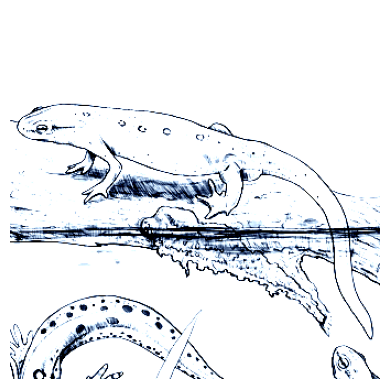

In [10]:
path = '/kaggle/input/mva-recvis-2024/sketch_recvis2024/sketch_recvis2024/test_images/mistery_category/img_215f0.jpeg'
image = Image.open(path)
image_input = transforms_(image).permute(1,2,0)
# Define transformations
transform = transforms_
image_=transform(image).permute(1,2,0)
a=image_

plt.imshow(a)
plt.axis('off')  # Masquer les axes pour une meilleure visualisation
plt.show()

In [11]:
# Load datasets
transform_ = transform

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_)
val_dataset = datasets.ImageFolder(root=test_dir, transform=transform_)

In [12]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(data)
print(num_classes)
model_ft = EVA_finetuner(model, num_classes).to(device)


500


In [14]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, focusing only on the classifier (head) parameters
optimizer = optim.Adam(model_ft.model.head.parameters(), lr=1e-4)

In [15]:
from tqdm import tqdm

# Number of epochs for training
num_epochs =5

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = len(val_loader) * 64  # Initialize total samples counter
    val_loss = 0.0  # Initialize validation loss

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(outputs, labels)  # Calculate the loss
            val_loss += loss.item()  # Update validation loss

            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            correct += (predicted == labels).sum().item()  # Update correct predictions

    avg_val_loss = val_loss / len(val_loader)  # Calculate average validation loss
    val_accuracy = 100 * correct / total  # Calculate validation accuracy

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')  # Print validation loss and accuracy for the epoch

    # Save the fine-tuned model for each epoch
    torch.save(model_ft.state_dict(), f'/kaggle/working/eva_finetuned_epoch_{epoch+1}_acc_{val_accuracy:.2f}.pth')


Epoch 1/5, Loss: 3.1069: 100%|██████████| 313/313 [1:20:39<00:00, 15.46s/it]


Epoch [1/5], Loss: 3.1069
Validation Loss: 1.0778, Validation Accuracy: 81.29%


Epoch 2/5, Loss: 0.7383: 100%|██████████| 313/313 [1:18:47<00:00, 15.10s/it]


Epoch [2/5], Loss: 0.7383
Validation Loss: 0.6452, Validation Accuracy: 83.55%


Epoch 3/5, Loss: 0.4908: 100%|██████████| 313/313 [1:18:44<00:00, 15.09s/it]


Epoch [3/5], Loss: 0.4908
Validation Loss: 0.5359, Validation Accuracy: 85.08%


Epoch 4/5, Loss: 0.3861: 100%|██████████| 313/313 [1:19:52<00:00, 15.31s/it]


Epoch [4/5], Loss: 0.3861
Validation Loss: 0.4828, Validation Accuracy: 85.43%


Epoch 5/5, Loss: 0.3189: 100%|██████████| 313/313 [1:18:54<00:00, 15.13s/it]


Epoch [5/5], Loss: 0.3189
Validation Loss: 0.4400, Validation Accuracy: 86.88%


In [16]:
import os
import csv

# Set the model to evaluation mode
model_ft.eval()

# Define the directory to save predictions
predict_dir = "/kaggle/working/predict.csv"

# Make sure the output directory exists
os.makedirs(os.path.dirname(predict_dir), exist_ok=True)

# Open the CSV file in write mode
with open(predict_dir, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Category"])  # Write header row
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, names in dataloader:
            images = images.to(device) # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            
            # Get the class label with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            
            # Loop through each image in the batch
            for i in range(len(names)):
                image_name = names[i]  # Get the image name (assuming it's in 'names')
                prediction = predicted[i].item()  # Get the predicted class label
                
                # Write image name and predicted label to the CSV file
                writer.writerow([image_name, prediction])
                
                # Optionally, print out predictions (or handle differently)
                print(f"Image: {image_name}, Predicted label: {prediction}")



NameError: name 'dataloader' is not defined